**`학습 내용 요약`**
- 3장에서 살펴본 차원 축소 기법을 사용해 2장에서 소개한 '신용카드 사기 탐지 데이터'를 활용해 시스템 구축

In [1]:
"""기본 라이브러리"""
import pandas as pd
import numpy as np
import os, sys
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

"""데이터 준비 및 모델 평가 관련 라이브러리"""
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

"""알고리즘 관련 라이브러리"""
from sklearn.decomposition import PCA

%matplotlib inline

fm.get_fontconfig_fonts()
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus = False)

%config lnlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# ***4.1 함수 정의***

In [2]:
# 이상치 스코어 함수 정의
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss, index = originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

# 평가 지표 정의
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis = 1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore']) 
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])


    plt.step(recall, precision, color = 'k', alpha = 0.7, where = 'post')
    plt.fill_between(recall, precision, step = 'post', alpha = 0.3, color = 'k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve : Average Precision = {0:0.2f}'.format(average_precision))
    
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color = 'r', lw = 2, label = 'ROC curve')
    plt.plot([0,1], [0,1], color = 'k', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic : Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc = 'lower right')
    plt.show()
    
    if returnPreds == True:
        return preds
    

# 시각화 함수 정의
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:, 0:1], index = xDF.index)
    tempDF = pd.concat([tempDF, yDF], axis=1, join='inner')
    tempDF.columns = ['First Vector', 'Second Vector', 'Label']
    sns.lmplot(x = 'First Vector', y = 'Second Vector', hue = 'Label', data = tempDF, fit_reg = False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using " + algoName)

# ***DATA LOAD***

In [3]:
# 데이터 로드하기
current_path = os.getcwd()
file = './datasets/credit_card_data/credit_card.csv'
data = pd.read_csv(current_path+file)

datax = data.copy().drop(['Class'], axis = 1)
datay = data['Class'].copy()

featuresToScale = datax.columns
sX = pp.StandardScaler(copy = True)
datax.loc[:, featuresToScale] = sX.fit_transform(datax[featuresToScale])

x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size = 0.33, random_state = 2018, stratify = datay)


## ***4.2 일반 PCA를 활용한 이상치 탐지***

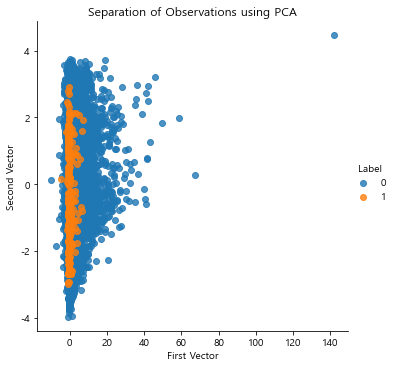

In [4]:
n_componets = 30
whiten = False
random_state = 2018

pca = PCA(n_components = n_componets, whiten=whiten, random_state = random_state) # whiten : 화이트닝 옵션으로 주성분의 스케일이 같아지도록 조정. 이는 화이트닝 옵션 없이 변환한 후에 standardscaler를 적용한 것과 동일.
x_train_pca = pca.fit_transform(x_train)
x_train_pca = pd.DataFrame(x_train_pca, index = x_train.index)

x_train_pca_inverse = pca.inverse_transform(x_train_pca)
x_train_pca_inverse = pd.DataFrame(x_train_pca_inverse, index = x_train.index)

scatterPlot(x_train_pca, y_train, 'PCA')

> PCA를 사용해 신용카드 거래 데이터셋의 내재된 구조를 학습합니다. 이 구조를 학습한 후 학습된 모델을 사용해 신용카드 거래를 재구성한 다음 재구성된 거래 데이터와 원본 거래 데이터가 얼마나 차이가 나는지 계산합니다. PCA를 통해 재구성이 가장 어려운 거래가 가장 비정상입니다. 

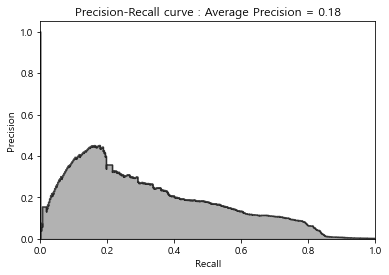

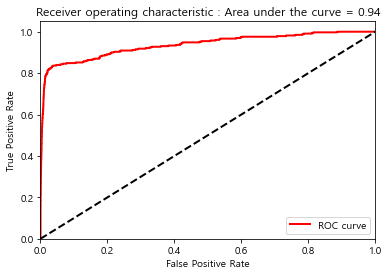

In [5]:
anomalyScoresPCA = anomalyScores(x_train, x_train_pca_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

> 평균 정밀도 0.18로 사용할 수 없는 사기 탐지 솔루션입니다. 이 솔루션은 매우 적은 수의 사기만 탐지합니다.

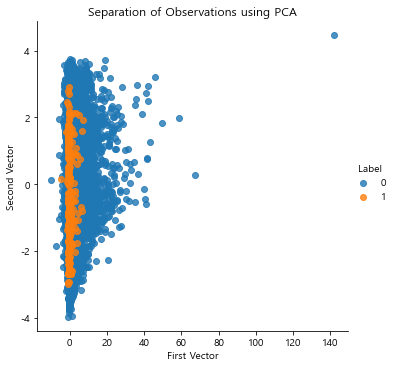

In [24]:
n_componets = 27
whiten = False
random_state = 2018

pca = PCA(n_components = n_componets, whiten=whiten, random_state = random_state) # whiten : 화이트닝 옵션으로 주성분의 스케일이 같아지도록 조정. 이는 화이트닝 옵션 없이 변환한 후에 standardscaler를 적용한 것과 동일.
x_train_pca = pca.fit_transform(x_train)
x_train_pca = pd.DataFrame(x_train_pca, index = x_train.index)

x_train_pca_inverse = pca.inverse_transform(x_train_pca)
x_train_pca_inverse = pd.DataFrame(x_train_pca_inverse, index = x_train.index)

scatterPlot(x_train_pca, y_train, 'PCA')

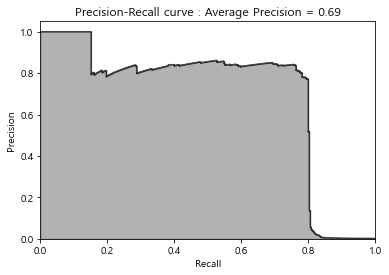

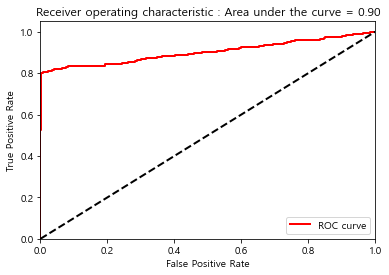

In [25]:
anomalyScoresPCA = anomalyScores(x_train, x_train_pca_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

## ***4.3 희소 PCA를 활용한 이상치 탐지***

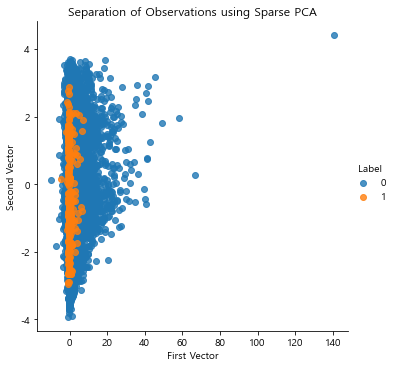

In [15]:
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components = n_components, alpha = alpha, random_state = random_state, n_jobs = n_jobs)
sparsePCA.fit(x_train.loc[:,:])
x_train_sparsePCA = sparsePCA.transform(x_train)

x_train_sparsePCA = pd.DataFrame(x_train_sparsePCA, index = x_train.index)
scatterPlot(x_train_sparsePCA, y_train, "Sparse PCA")

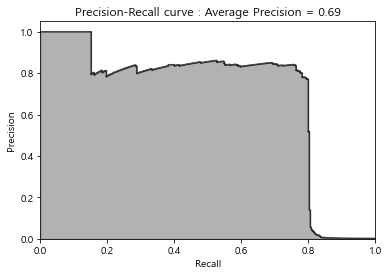

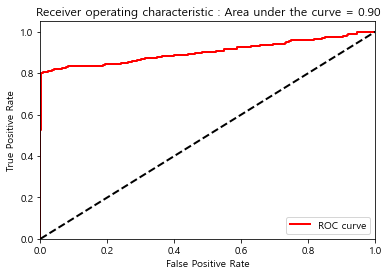

In [19]:
x_train_sparsePCA_inverse = np.array(x_train_sparsePCA).dot(sparsePCA.components_)+np.array(x_train.mean(axis=0))
x_train_sparsePCA_inverse = pd.DataFrame(x_train_sparsePCA_inverse, index = x_train.index)

anomalyScoresSparsePCA = anomalyScores(x_train, x_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

> 일반적으로 pca에서 주성분을 생성할 때 평균 빼기(혹은 평균 중심화)를 가장 먼저 진행하므로 역변환에서 마지막에 평균을 더해야합니다. 

## ***4.4 커널 PCA를 활용한 이상치 탐지***
- 비선형 계열의 PCA로 사기 거래가 정상 거래와 선형으로 구분되지 않는 경우에 유용

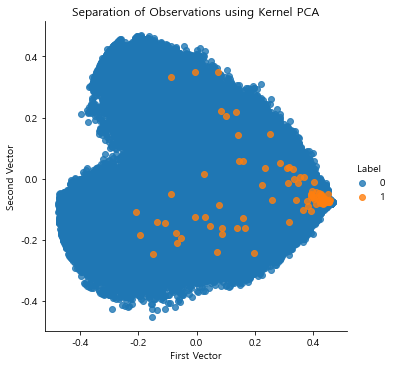

In [7]:
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components = n_components, kernel = kernel, gamma=gamma, fit_inverse_transform = fit_inverse_transform, n_jobs = n_jobs, random_state = random_state)
kernelPCA.fit(x_train.iloc[:2000])
x_train_kernelPCA = kernelPCA.transform(x_train)
x_train_kernelPCA = pd.DataFrame(data = x_train_kernelPCA, index = x_train.index)

x_train_kernelPCA_inverse = kernelPCA.inverse_transform(x_train_kernelPCA)
x_train_kernelPCA_inverse  = pd.DataFrame(data = x_train_kernelPCA_inverse, index = x_train.index)

scatterPlot(x_train_kernelPCA, y_train, "Kernel PCA") 


> 커널PCA의 결과는 일반PCA와 희소PCA의 결과보다 훨씬 나쁩니다. 

## ***4.5 GRP 활용한 이상치 탐지***

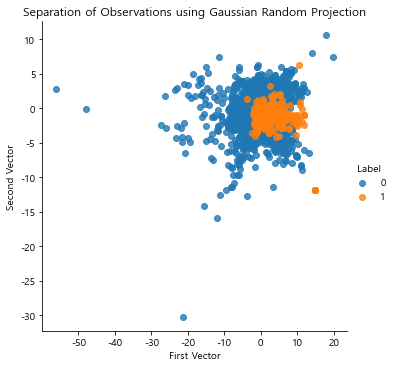

In [8]:
from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components = n_components, eps = eps, random_state = random_state)

x_train_GRP = GRP.fit_transform(x_train)
x_train_GRP = pd.DataFrame(data = x_train_GRP, index = x_train.index)

scatterPlot(x_train_GRP, y_train, "Gaussian Random Projection")

> 주성분 개수 또는 존슨-린덴슈트라우스 보조정리에 따라 파생된 임베딩 품질을 제어하는 eps 파라미터를 설정할 수 있습니다. 본 예제에서는 더 명시적인 옵션인 주성분 개수만 설정합니다. 

> 가우시안 랜덤 투영은 속도가 매우 빠르나 희소PCA와 마찬가지로 사이킷런에서 제공하는 함수가 없기 때문에 inverse_transform 함수를 직접 구현해야합니다. 

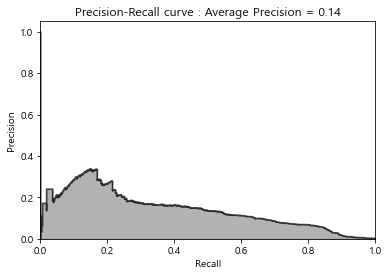

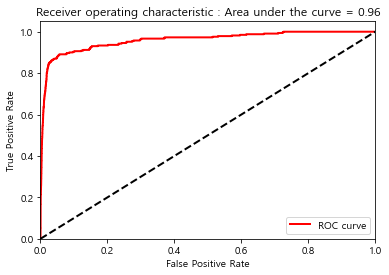

In [9]:
x_train_GRP_inverse = np.array(x_train_GRP).dot(GRP.components_)+np.array(x_train.mean(axis=0))
x_train_GRP_inverse = pd.DataFrame(x_train_GRP_inverse, index = x_train.index)

anomalyScoresx_train_GRP = anomalyScores(x_train, x_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresx_train_GRP, True)

## ***4.6 SRP를 활용한 이상치 탐지***

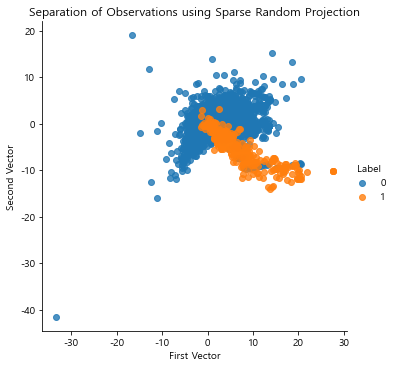

In [10]:
from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = 0.01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components = n_components, density = density, eps = eps, dense_output = dense_output, random_state = random_state)

x_train_SRP = SRP.fit_transform(x_train)
x_train_SRP = pd.DataFrame(data = x_train_SRP, index = x_train.index)

scatterPlot(x_train_SRP, y_train, "Sparse Random Projection")

In [16]:
x_train_SRP_inverse = np.array(x_train_SRP).dot(SRP.components_)+np.array(x_train.mean(axis=0))
x_train_SRP_inverse = pd.DataFrame(x_train_SRP_inverse, index = x_train.index)

anomalyScoresx_train_SRP = anomalyScores(x_train, x_train_SRP_inverse)
preds = plotResults(y_train, anomalyScoresx_train_SRP, True)

ValueError: operands could not be broadcast together with shapes (190820,27) (30,) 

## ***4.7 비선형 이상치 탐지***
- 지금까지는 PCA를 사용한 솔루션이 가장 우수합니다. 
- 오픈소스 버전의 비선형 차원 감소 알고리즘 대부분은 실행 속도가 매우 느려서 사기 탐지 솔루션에 적합하지 않아 넘어가겠습니다.

## ***4.8 사전 학습을 활용한 이상치 탐지***
- 사전 학습 알고리즘은 원본 데이터로부터 희소 표현을 학습합니다.
- 이상 탐지를 위해 사전의 벡터 개수가 원본 차원보다 작도록 과소완전 사전을 학습할 겁니다.
- 이 제약을 사용하면 더 자주 발생하는 정상 거래를 재구성하는 것은 더 쉬워지고 희귀한 사기 거래를 재구성하는 것은 훨씬 더 어려워집니다.


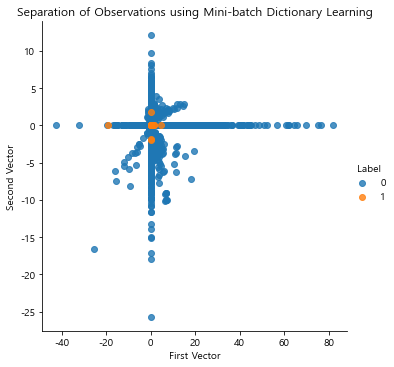

In [14]:
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning(n_components=n_componets, alpha = alpha, batch_size = batch_size, n_iter = n_iter, random_state=random_state)
miniBatchDictLearning.fit(x_train)
x_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(x_train)
x_train_miniBatchDictLearning = pd.DataFrame(x_train_miniBatchDictLearning, index = x_train.index)

scatterPlot(x_train_miniBatchDictLearning, y_train, "Mini-batch Dictionary Learning")

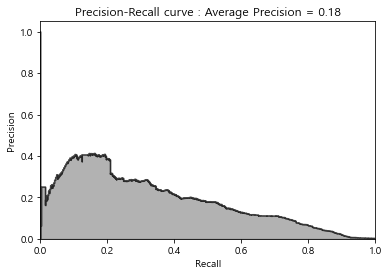

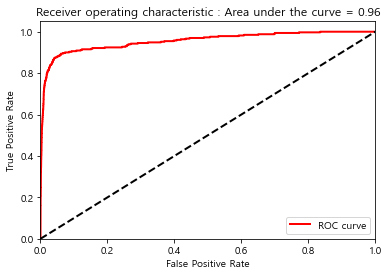

In [17]:
x_train_miniBatchDictLearning_inverse = np.array(x_train_miniBatchDictLearning).dot(miniBatchDictLearning.components_)+np.array(x_train.mean(axis=0))
x_train_miniBatchDictLearning_inverse = pd.DataFrame(x_train_miniBatchDictLearning_inverse, index = x_train.index)

anomalyScoresminiBatchDictLearning = anomalyScores(x_train, x_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresminiBatchDictLearning, True)

> 커널PCA, 가우시안 랜덤 투영, 희소 랜덤 투영보다는 훨씬 좋지만 일반 PCA의 결과와는 비교가 되지 않습니다. 

## ***4.9 ICA를 활용한 이상치 탐지***

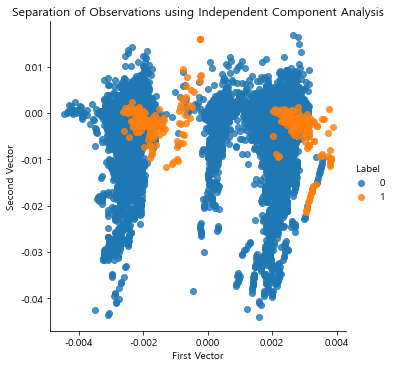

In [21]:
from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, algorithm=algorithm, whiten = whiten, max_iter = max_iter, random_state=random_state)

x_train_fastICA = fastICA.fit_transform(x_train)
x_train_fastICA = pd.DataFrame(data = x_train_fastICA, index = x_train.index)

x_train_fastICA_inverse = fastICA.inverse_transform(x_train_fastICA)
x_train_fastICA_inverse = pd.DataFrame(data = x_train_fastICA_inverse, index = x_train.index)

scatterPlot(x_train_fastICA, y_train, "Independent Component Analysis")

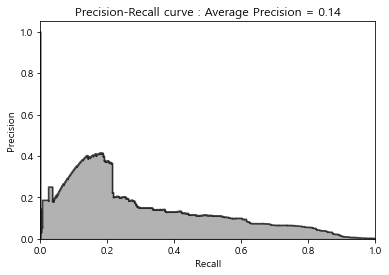

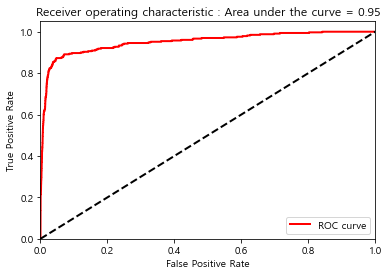

In [22]:
x_train_fastICA_inverse = np.array(x_train_fastICA).dot(fastICA.components_)+np.array(x_train.mean(axis=0))
x_train_fastICA_inverse = pd.DataFrame(x_train_fastICA_inverse, index = x_train.index)

anomalyScoresfastICA = anomalyScores(x_train, x_train_fastICA_inverse)
preds = plotResults(y_train, anomalyScoresfastICA, True)

## ***4.10 테스트셋으로 이상치 탐지 성능 평가***
- 지금까지 개발한 솔루션 중에서 성능이 가장 좋은 일반PCA 솔루션을 적용하겠습니다.

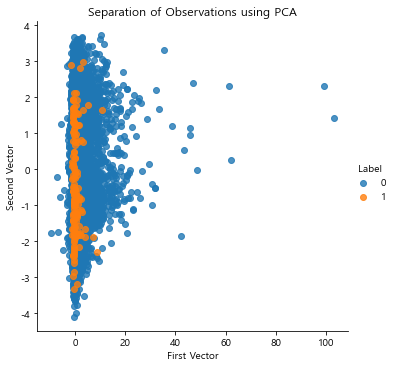

In [26]:
x_test_PCA = pca.transform(x_test)
x_test_PCA = pd.DataFrame(data=x_test_PCA, index = x_test.index)

x_test_PCA_inverse = pca.inverse_transform(x_test_PCA)
x_test_PCA_inverse = pd.DataFrame(data = x_test_PCA_inverse, index = x_test.index)

scatterPlot(x_test_PCA, y_test, "PCA")

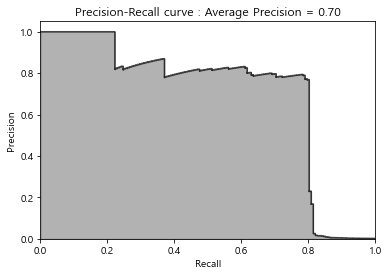

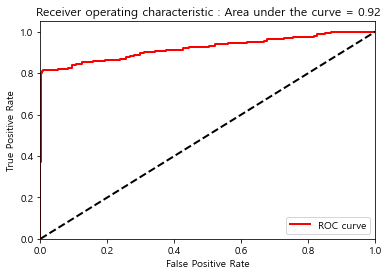

In [27]:
anomalyScorePCA = anomalyScores(x_test, x_test_PCA_inverse)
preds = plotResults(y_test, anomalyScorePCA, True)

> 결과는 매우 인상적입니다. 테스트셋에서 정밀도 80%로 알려진 사기의 80%를 포착할 수 있습니다. 물론 레이블을 사용하지 않고 개발한 결과입니다!!